In [1]:
from windrose import WindroseAxes
from matplotlib import pyplot
import matplotlib.cm as cm
import requests
import numpy
from dotenv import dotenv_values
from datetime import date, timedelta, datetime
from time import sleep
import csv
from pathlib import Path

ECOWITT_DEVICE_ID = "58371"
START_DATE = date(2021, 8, 22)
END_DATE = date.today()

In [2]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)


def payload(sdate, edate):
    return {
        "device_id": ECOWITT_DEVICE_ID,
        "is_list": "0",
        "mode": "0",
        "sdate": sdate,
        "edate": edate,
        "page": "1",
        "sortList": "0|2|3|4|5|24|999",
        "hideList": "",
    }


def is_calm(wind_speed):
    """
    Filter off "calm" winds (less than 3mph)
    """
    if wind_speed < 3:
        return True
    return False


def read_historical_data_in_daterange():
    """
    Returns a dict
    {
        date1: [3-ple of data,...],
        date2: [3-ple of data,...],
        ...
    }
    """
    p = Path('data').glob('*.csv')
    ret = {}
    for csvfile in p:
        with open(csvfile,'r') as fd:
            csv_reader = csv.reader(fd, delimiter=',')
            for row in csv_reader:
                this_rows_date = datetime.strptime(row[0],'%Y-%m-%d %H:%M').date()
                this_rows_date_str = this_rows_date.strftime("%Y-%m-%d")
                if START_DATE <= this_rows_date <= END_DATE:
                    if not ret.get(this_rows_date_str):
                        ret[this_rows_date_str] = []
                    ret[this_rows_date_str].append((row[0],int(row[1]),float(row[2])))
    return ret

config = dotenv_values(".env")
req_ses = requests.session()
req_ses.post(
    "https://webapi.www.ecowitt.net/user/site/login",
    data={
        "account": config.get("USER"),
        "password": config.get("PASSWORD"),
        "authorize": "",
    },
)

def fetch_from_api(day):
    d = req_ses.post(
        "https://webapi.www.ecowitt.net/index/get_data",
        data=payload(day.strftime("%Y-%m-%d 00:00"), day.strftime("%Y-%m-%d 23:59")),
    ).json()
    dimensions = d.get("list")
    wind_speed = dimensions.get("wind_speed").get("list").get("windspeedmph")
    wind_dir = dimensions.get("winddir").get("list").get("winddir")
    times = d.get("times")
    return ([
            (x[0], x[1], float(x[2]))
            for x in list(zip(times, wind_dir, wind_speed))
            if x[1] != "" and x[2] != ""
        ])

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)


def payload(sdate, edate):
    return {
        "device_id": ECOWITT_DEVICE_ID,
        "is_list": "0",
        "mode": "0",
        "sdate": sdate,
        "edate": edate,
        "page": "1",
        "sortList": "0|2|3|4|5|24|999",
        "hideList": "",
    }


def normalize_calm(entry):
    """Change anything below 3mph to calm"""
    if entry[1] < 3:
        return (0, 0.0)
    return entry



In [3]:
historical = read_historical_data_in_daterange()

all_data = []
csv_data = []
csv_dates = []

for day in daterange(START_DATE, END_DATE):
    str_formatted_date = day.strftime("%Y-%m-%d")
    if historical.get(str_formatted_date):
        all_data.extend(historical[str_formatted_date])
    else:
        date_data = fetch_from_api(day)
        all_data.extend(date_data)
        csv_data.extend(date_data)
        csv_dates.append(day)
        sleep(0.5)

if len(csv_dates) > 0:
    sorted_csv_dates = sorted(csv_dates)
    first_csv_date = sorted_csv_dates[0].strftime("%Y%m%d")
    last_csv_date = sorted_csv_dates[-1].strftime("%Y%m%d")

    with open(
        f'data/{first_csv_date}-{last_csv_date}.csv', "w"
    ) as fd:
        write = csv.writer(fd)
        write.writerows(csv_data)

wd = numpy.array([x[1] for x in all_data if not is_calm(x[2]) ])
ws = numpy.array([x[2] for x in all_data if not is_calm(x[2])])


# All data

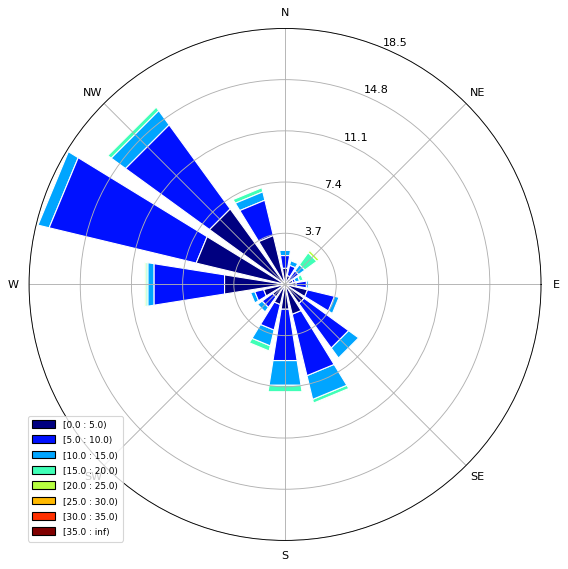

In [4]:
ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, bins=numpy.arange(0, 40, 5), edgecolor='white')
ax.set_xticklabels(['E', 'NE','N', 'NW', 'W', 'SW', 'S', 'SE'])
ax.set_legend()


# Daytime

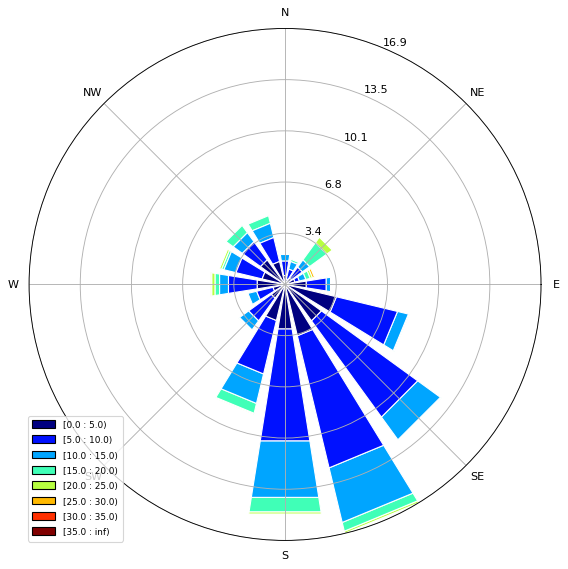

In [5]:
daytime = [x for x in all_data if 8 <= datetime.strptime(x[0], '%Y-%m-%d %H:%M').time().hour <= 18  ]
wd = numpy.array([x[1] for x in daytime if not is_calm(x[2]) ])
ws = numpy.array([x[2] for x in daytime if not is_calm(x[2])])
ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, bins=numpy.arange(0, 40, 5), edgecolor='white')
ax.set_xticklabels(['E', 'NE','N', 'NW', 'W', 'SW', 'S', 'SE'])
ax.set_legend()


# Nighttime

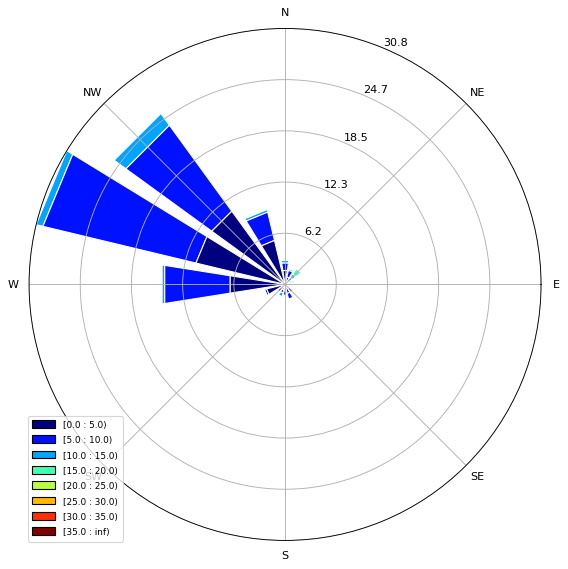

In [6]:
nighttime = [x for x in all_data if not 8 <= datetime.strptime(x[0], '%Y-%m-%d %H:%M').time().hour <= 18  ]
wd = numpy.array([x[1] for x in nighttime if not is_calm(x[2]) ])
ws = numpy.array([x[2] for x in nighttime if not is_calm(x[2])])
ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, bins=numpy.arange(0, 40, 5), edgecolor='white')
ax.set_xticklabels(['E', 'NE','N', 'NW', 'W', 'SW', 'S', 'SE'])
ax.set_legend()